These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from integrators import contact as ic
from integrators.common import rk4

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si

In [4]:
def D(system, dt,p,q,s,t):
    t += dt
    return p,q,s,t

def C(system, dt,p,q,s,t):
    q += s*dt
    p /= 1. + p*dt
    return p,q,s,t 

def B(system, dt,p,q,s,t):
    p -= system.Vq(q, t)*dt
    s -= system.V(q, t)*dt
    return p,q,s,t

def A(system, dt,p,q,s,t):
    f_q = system.f(q)
    fq_q = system.fq(q)
    ex = np.exp(-dt*f_q)
    p = (p + fq_q*s*dt)*ex
    s *= ex
    return p,q,s,t
    
def step1(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (C,0.5), (B,0.5), (A,1), (B,0.5), (C,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step2(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (A,0.5), (B,0.5), (C,1), (B,0.5), (A,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [5]:
class Lienard:
    def __init__(self, f, fq, F, Fq):
        self.f = f
        self.fq = fq
        self.F = F
        self.Fq = Fq
    
    def f(self, q):
        return self.f(q)
    
    def fq(self, q):
        return self.fq(q)
    
    def V(self, q, t):
        return self.F(q, t)
    
    def Vq(self, q, t):
        return self.Fq(q, t)

In [6]:
def vanDerPol(epsilon, a, omega):
    
    def f(q):
        return -epsilon*(1 - q**2)
    def fq(q):
        return 2*epsilon*q
    def F(q, t):
        return q - a*np.cos(omega*t)
    def Fq(q, t):
        return 1
    
    return Lienard(f, fq, F, Fq)

In [7]:
def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

def omega(t,e):
    o=((1 - e**2/16. + (17*e**4)/3072. + t**2/24. + (27*e**2*t**2)/128. +
    (781*e**4*t**2)/73728. + (3*t**4)/640. + (149*e**2*t**4)/2048. -
    (339041*e**4*t**4)/3.538944e6 + (5*t**6)/7168. + (559*e**2*t**6)/16384. +
    (4695149*e**4*t**6)/8.4934656e7))/(2*np.pi)
    return o

## Orbits $\epsilon = 0$

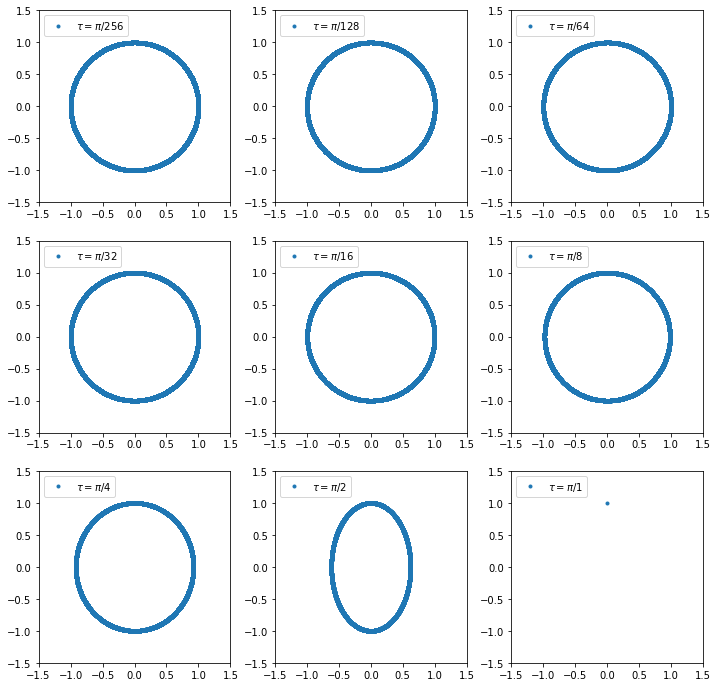

In [10]:
tf = 10000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))
for fact, spl in [(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]:
    tspan = np.arange(0, tf, np.pi/fact)
    plt.subplot(spl)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,
             '.',label=r"$\tau = \pi $/" f"${fact}$")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.legend(loc='upper left')

plt.show()

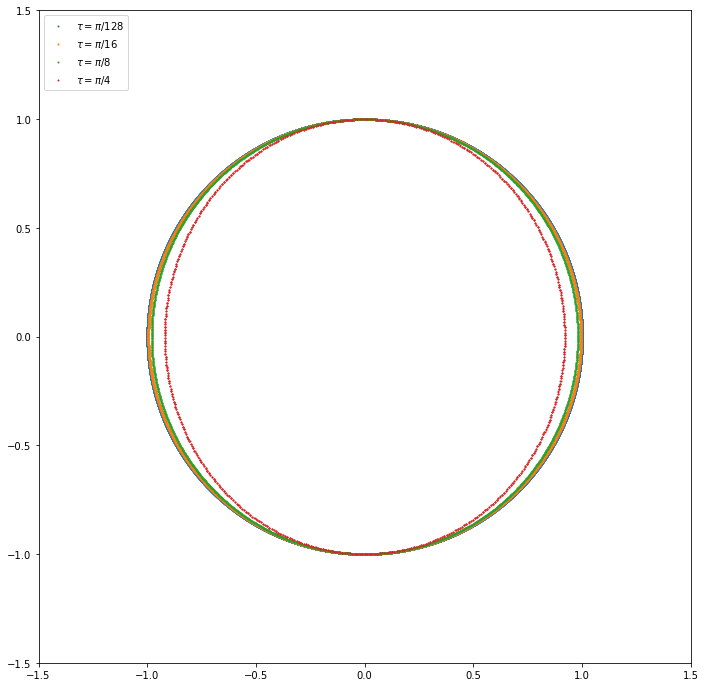

In [8]:
tf = 1000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))

for fact in [128,16,8,4]:
    tspan = np.arange(0, tf, np.pi/fact)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,'.',
             label=r"$\tau = \pi $/" f"${fact}$",
             markersize=2)
    
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon=0$

In [ ]:
#we have to fix the function of the Modified Hamiltonian as O(tau^8)
#and also insert a comparison with the different choice of the modified Hamiltonian.

In [98]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0]
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(0, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

T[T != 0]
#I don't know how to not print the output

array([6.2831851 , 6.28318416, 6.28318322, 6.28318165, 6.28317882,
       6.28317662, 6.28317316, 6.28316782, 6.28316248, 6.28315839,
       6.28315368, 6.28314645, 6.28314268, 6.28313136, 6.28312854,
       6.28311754, 6.28310811, 6.28309742, 6.28308862, 6.28307982,
       6.28307197, 6.28306034, 6.28304777, 6.28303708, 6.28302168,
       6.28301194, 6.28298994, 6.28298177, 6.28296574, 6.28295412,
       6.2829362 , 6.28292143, 6.28290132, 6.28287304, 6.28286298,
       6.28284852, 6.28282558, 6.28280201, 6.28278724, 6.28276556,
       6.28274104, 6.28272219, 6.28268919, 6.28268008, 6.28264771,
       6.28264299, 6.28260905, 6.28258454, 6.2825638 , 6.28252671,
       6.2825044 , 6.28247266, 6.28244877, 6.28242992, 6.28239315,
       6.28236907, 6.2823282 , 6.28228796, 6.28228513, 6.28225086,
       6.28221377, 6.28219239, 6.28213581, 6.28209997, 6.28207325,
       6.28203395, 6.28201352, 6.28197296, 6.28195002, 6.28191135,
       6.28185948, 6.2818303 , 6.28178536, 6.28174419, 6.28170

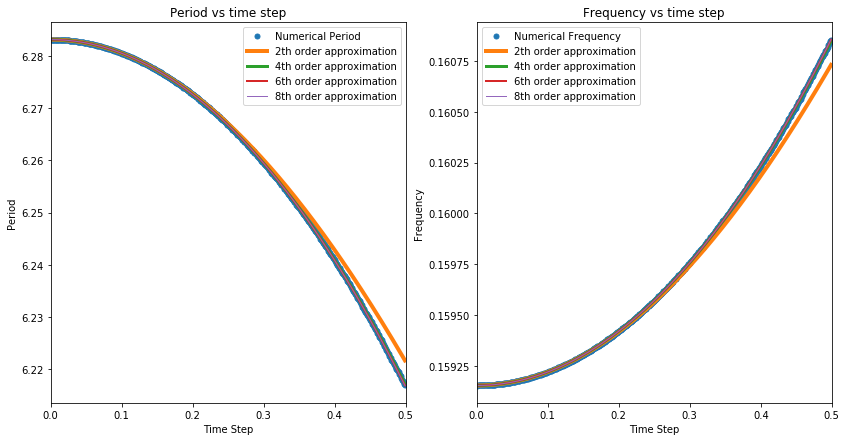

In [100]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2)*
                       (1260 + 210*dt**2))/(5040.*np.pi)),
         label="2th order approximation",linewidth=4)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4)*
                       (1260 + 210*dt**2 + 42*dt**4))/(5040.*np.pi)),
         label="4th order approximation",linewidth=3)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6))/(5040.*np.pi)),
         label="6th order approximation",linewidth=2)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi)),
         label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,np.sqrt((5040 - 420*dt**2)*
                    (1260 + 210*dt**2))/(5040.*np.pi),
        label="2th order approximation",linewidth=4)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4)*
                    (1260 + 210*dt**2 + 42*dt**4))/(5040.*np.pi),
        label="4th order approximation",linewidth=3)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6))/(5040.*np.pi),
        label="6th order approximation",linewidth=2)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi),
        label="8th order approximation",linewidth=1)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

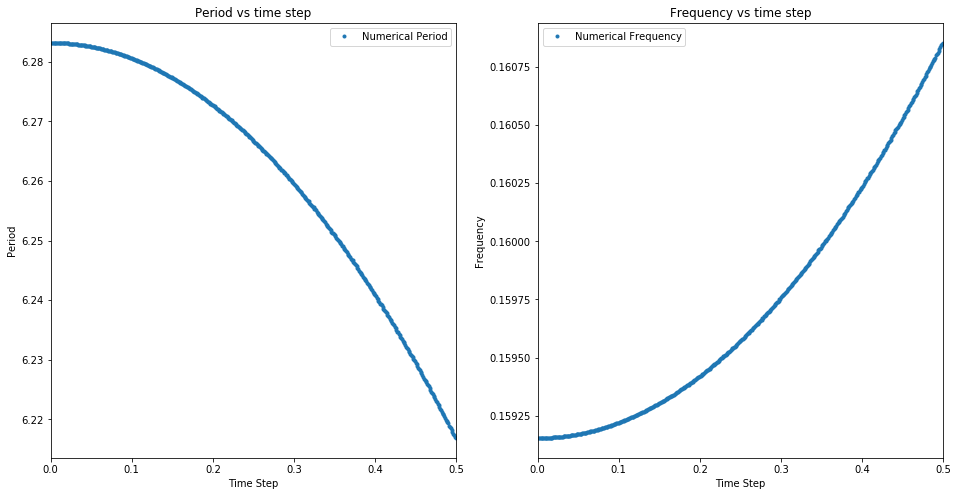

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## Orbits $\epsilon \sim 1$

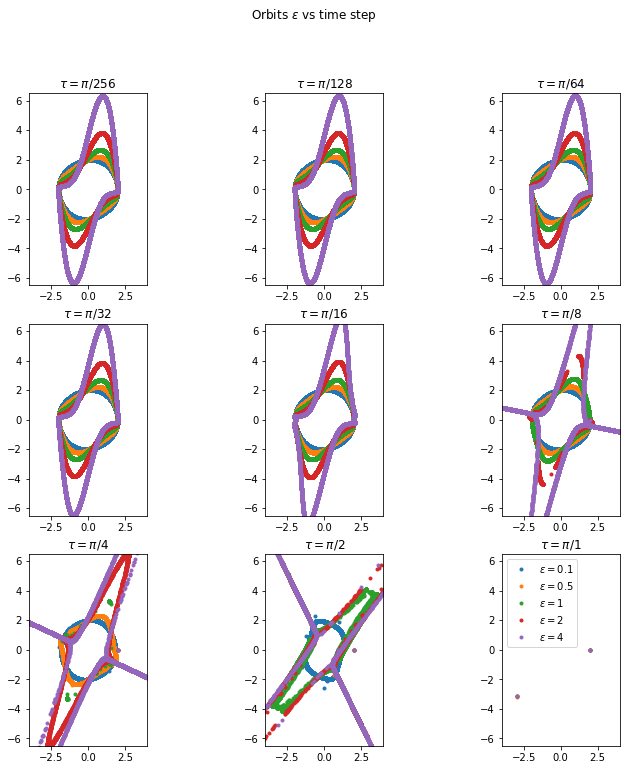

In [13]:
tf = 10000
p0, q0, s0 = 0, 2, 0
plt.figure(figsize=(12,12))
elist=[0.1,0.5,1,2,4]
plt.suptitle(r"Orbits $\epsilon$ vs time step")
steps=[(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]
for fact, spl in steps:
    for epsilon in elist:
        vdp = vanDerPol(epsilon, 0, 0)
        tspan = np.arange(0, tf, np.pi/fact)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = \pi /" f"${fact}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sols,'.',
                 label=r"$\epsilon = $" f"${epsilon}$")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim((-4,4))
        plt.ylim((-6.5,6.5))


plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon\sim1$.

In [10]:
tf = 100
tau=0.4
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0.1,0.3,
       0.5,0.7,
       0.9,1.1,
       1.3,1.5,
       1.7,1.9]
dt=np.arange(0.001,0.5,0.001)
T=np.zeros((len(dt),len(elist)))
k=-1

for epsilon in elist:
    k+=1
    for factor in range(len(dt)):
        t=np.zeros(int(tf))
        tspan = np.arange(0, tf, dt[factor])
        vdp = vanDerPol(epsilon, 0, 0)
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        maxi=np.zeros(10000)
        ns=int(tf/dt[factor])-1
        j=0
        for i in range(ns):
            if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
                maxi[j]=tspan[i]
                j+=1
        for i in range(1,j-1):
            t[i]=(maxi[i+1]-maxi[i])
            T[factor,k]+=t[i]
        T[factor,k]=T[factor,k]/(j-2)

T[T != 0]    

array([6.28707143, 6.3185    , 6.38069231, ..., 6.21830769, 6.02126667,
       3.95041667])

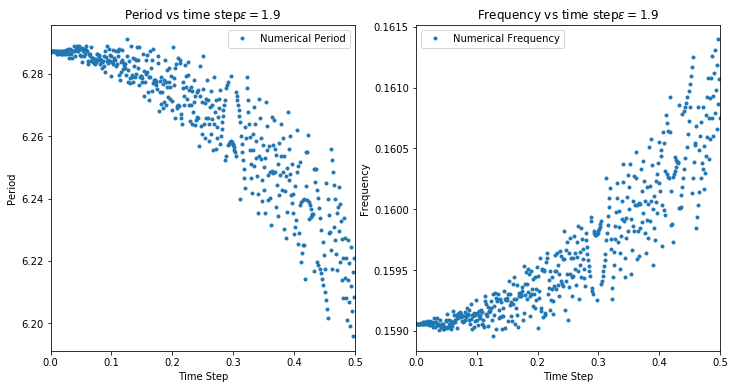

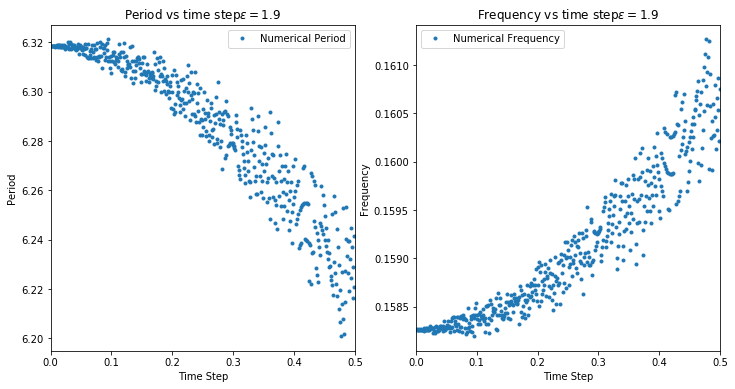

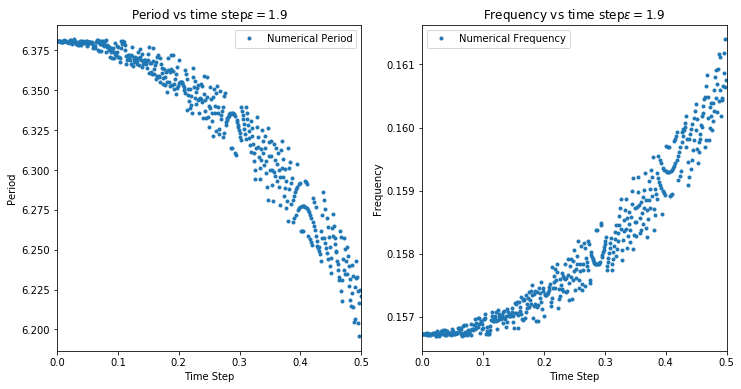

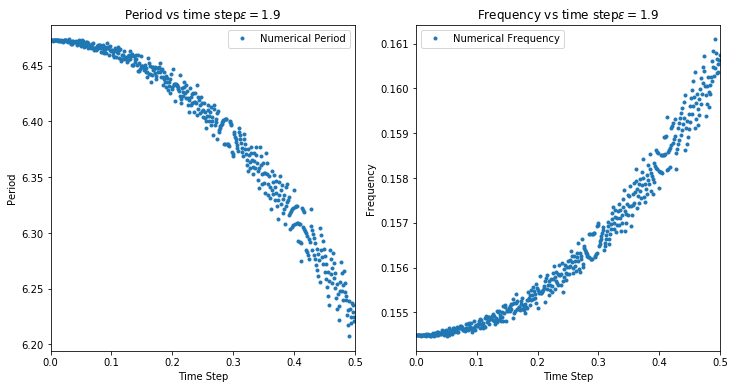

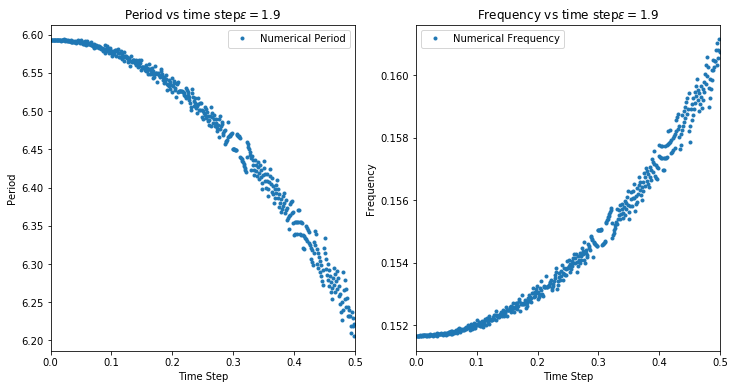

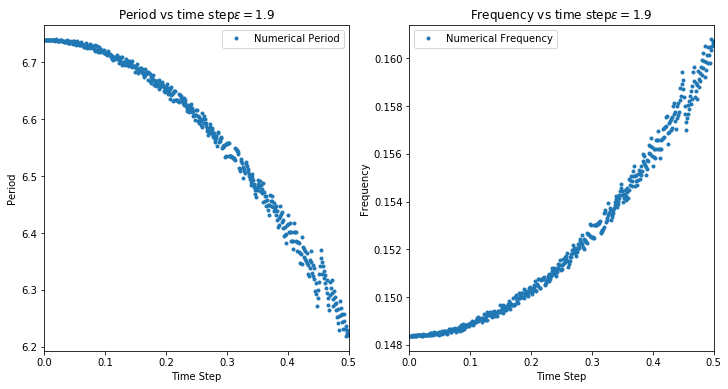

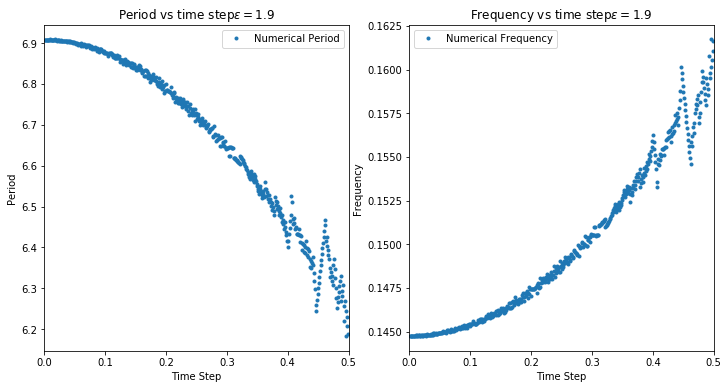

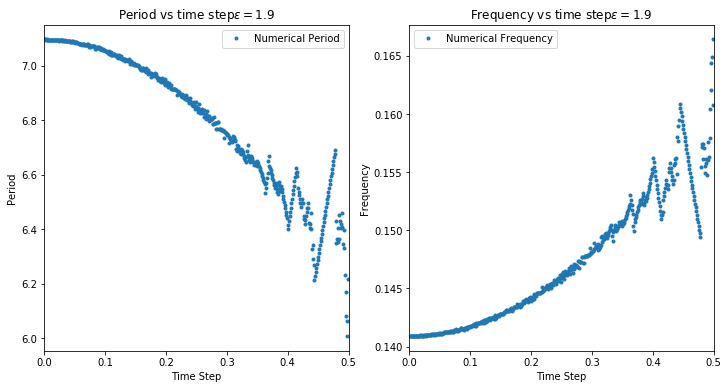

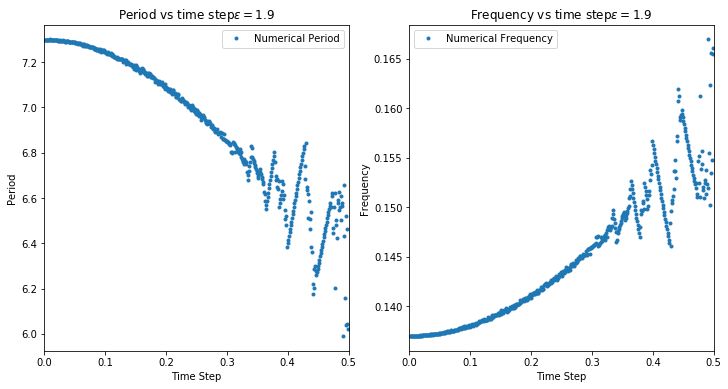

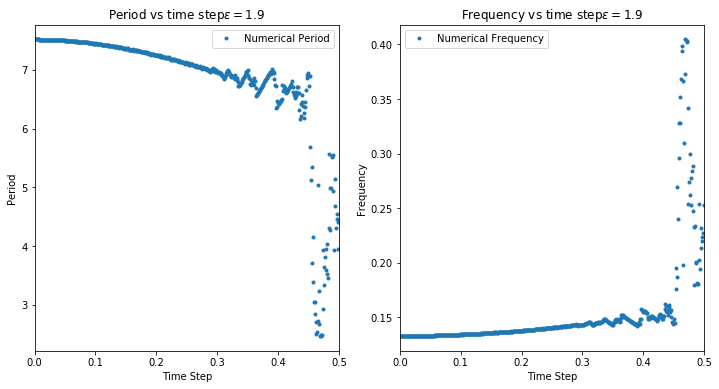

In [17]:
for i in range(len(elist)):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.gca().set_title("Period vs time step" r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period")
    plt.xlim((0,0.5))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='bottom left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step" r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency")
    plt.xlim((0,0.5))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.legend(loc='upper left')
    plt.show()

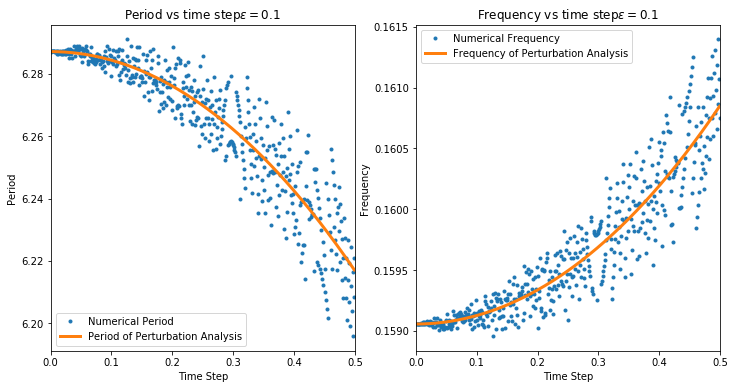

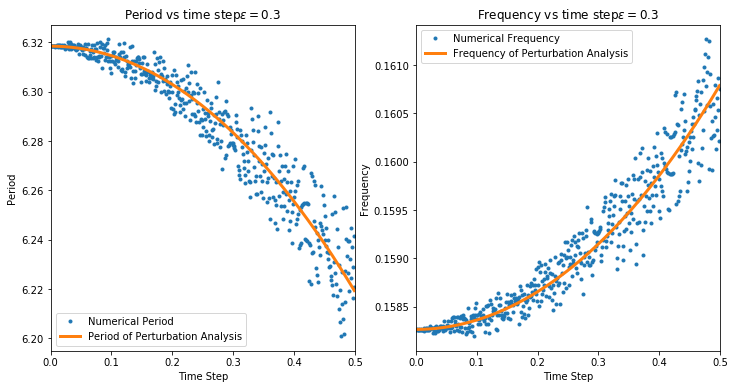

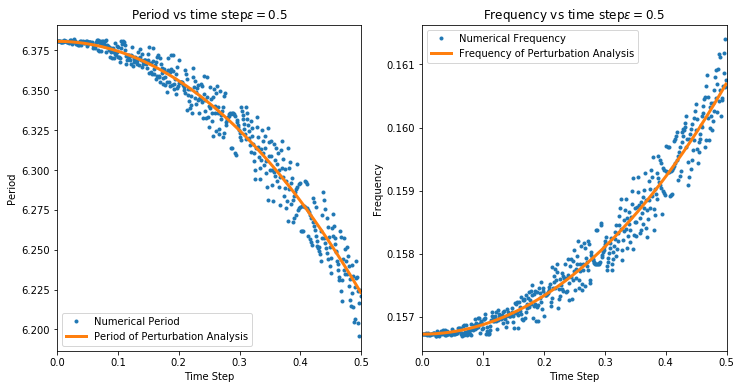

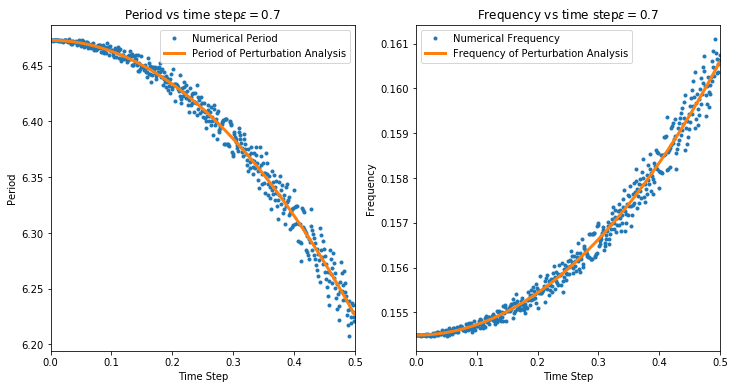

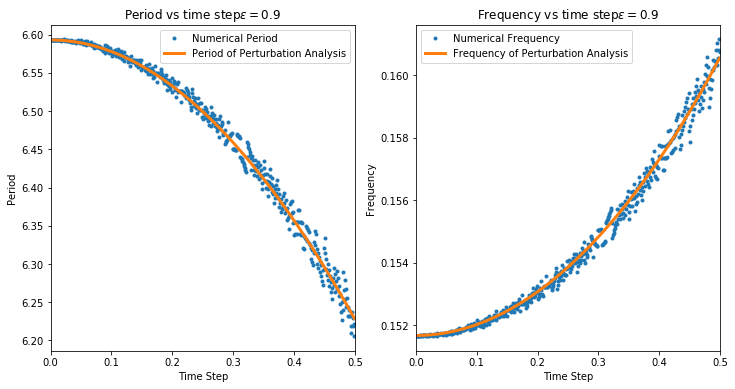

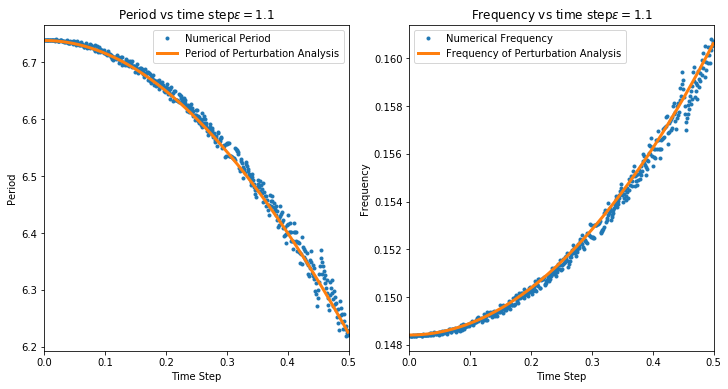

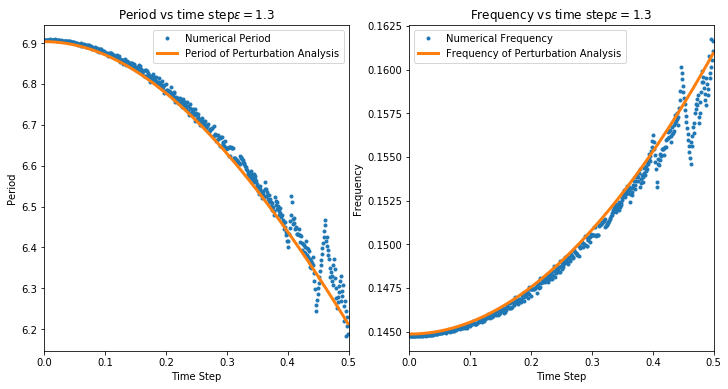

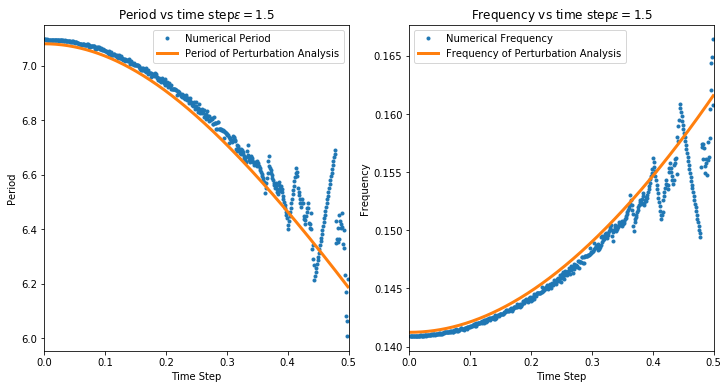

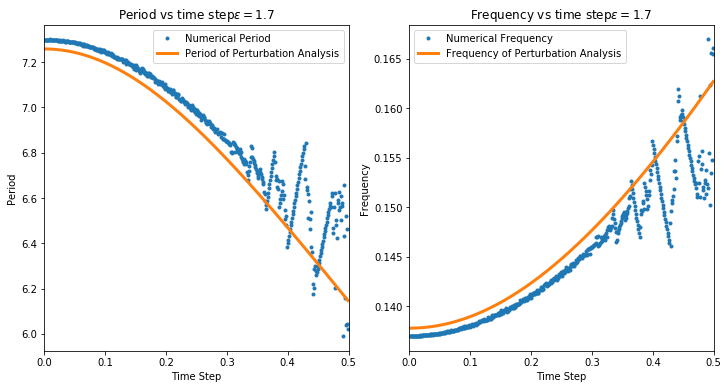

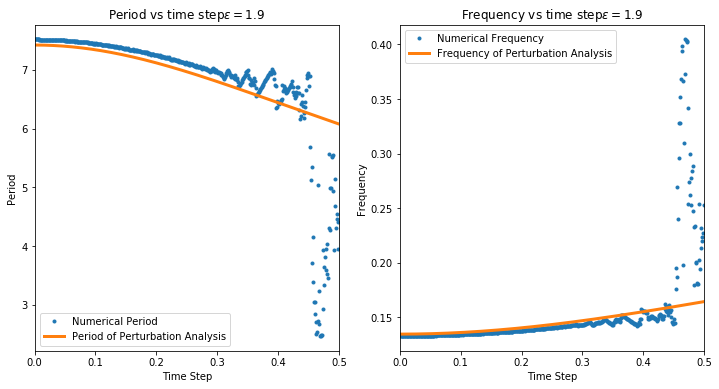

In [16]:
for i in range(len(elist)):
    plt.figure(figsize=(12,6))
    epsilon=elist[i]
    plt.subplot(121)
    plt.gca().set_title("Period vs time step" r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,T[:,i],'.',label="Numerical Period")
    plt.plot(dt,1/(omega(dt,epsilon)),
             label="Period of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.5))
    plt.ylabel("Period")
    plt.xlabel("Time Step")
    plt.legend(loc='bottom left')

    plt.subplot(122)
    plt.gca().set_title("Frequency vs time step" r"$\epsilon = " f"${epsilon}")
    plt.plot(dt,1/T[:,i],'.',label="Numerical Frequency")
    plt.plot(dt,omega(dt,epsilon),
             label="Frequency of Perturbation Analysis",
             linewidth=3)
    plt.xlim((0,0.5))
    plt.ylabel("Frequency")
    plt.xlabel("Time Step")
    plt.legend(loc='upper left')
    plt.show()

## Orbits for $\epsilon \gg 1$

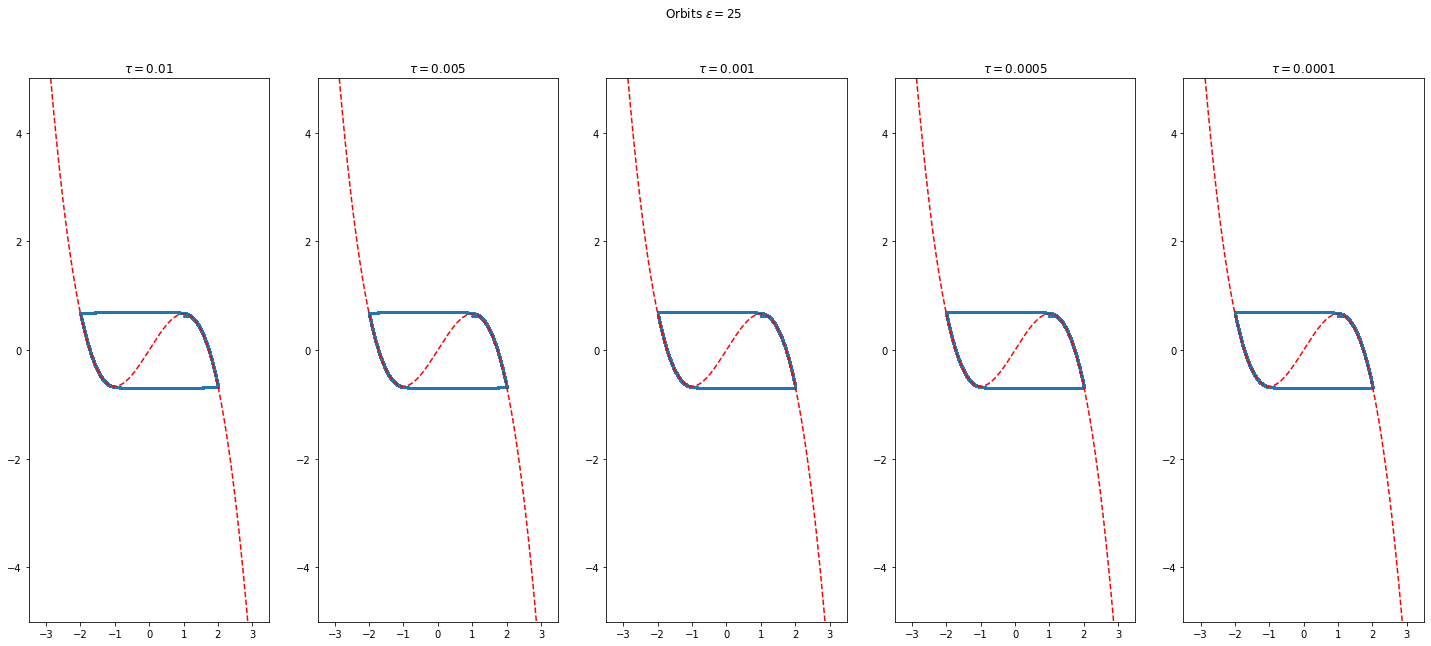

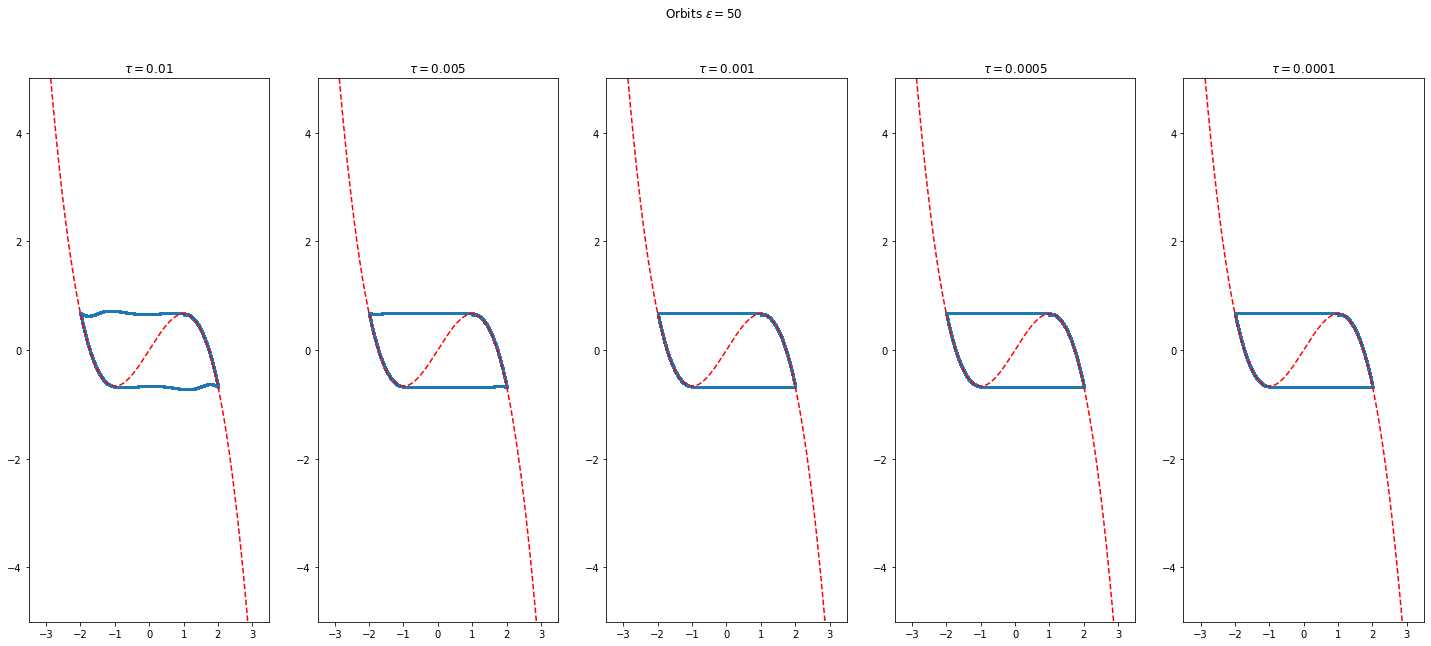

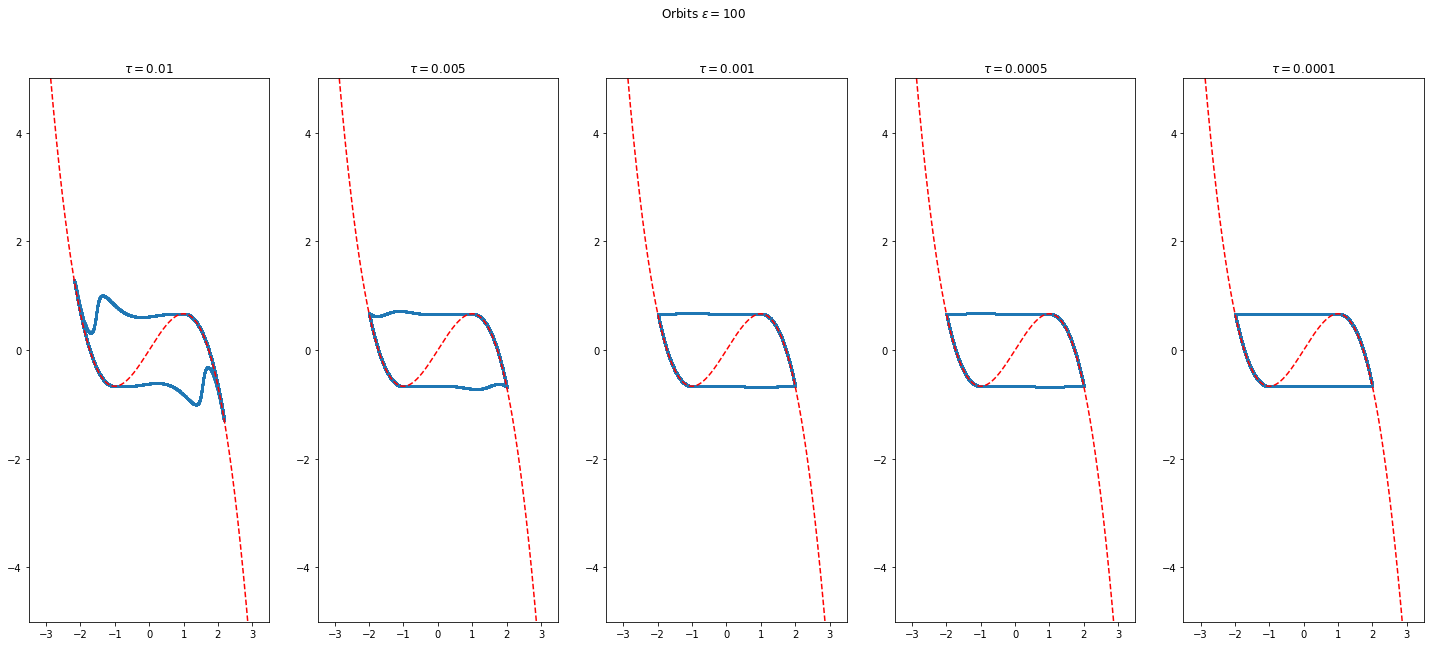

In [13]:
tf = 10000
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
for epsilon in elist:
    vdp = vanDerPol(epsilon, 0, 0)
    plt.figure(figsize=(15,10))
    plt.suptitle(r"Orbits $\epsilon =$" f"{epsilon}")
    for dt, spl in [(0.01,"151"),(0.005,"152"),(0.001,"153"),(0.0005,"154"),(0.0001,"155")]: 
        tspan = np.arange(0, dt*10**7, dt)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = " f"${dt}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/epsilon),
                 '.',markersize=3)
        plt.plot(x, x-(1/3)*(x)**3,'r--')
        plt.xlim((-3,3))
        plt.ylim((-2,2))
    plt.show()

## Forced Van Der Pol Oscillator

Forced Van der Pol Oscillator from: "Explicit methods in extended phase space for inseparable Hamiltonian problems", 
doi:10.1007/s10569-014-9597-9
$f(q) = - \epsilon (1-q^2)$ and $F(q,t) = q - A \cos(\frac{2 \pi t}{P})$.
Simulations parameters:

$\tau = 0.02$

$t_f = 500$

$\mu = 5$

$A = 5$

$P=\frac{2 \pi}{2.463}$

In [8]:
from scipy import integrate as si

def err(x, y):
    errv = np.empty(len(x))
    for i in range(len(x)):
        errv[i] = max(errv[i-1] if i > 0 else 0, abs(x[i]-y[i]))
    return errv

In [8]:
def ivp_vdp(y, t, mu, a, omega):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0] + a*np.cos(omega*t)
    ]

# dt = 0.02
tspan = np.arange(0, 500, 0.02)

y_init, params = [2, 2], (5, 5, 2.463)

y_odeint, info = si.odeint(ivp_vdp, y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 172671, number of Jacobian evaluations: 461


In [32]:
vdp = vanDerPol(5, 5, 2.463)
tspan = np.arange(0, 500, 0.02)

q0, p0, s0 = 2, 0, 2

sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, vdp, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, vdp, tspan, p0, q0, s0)

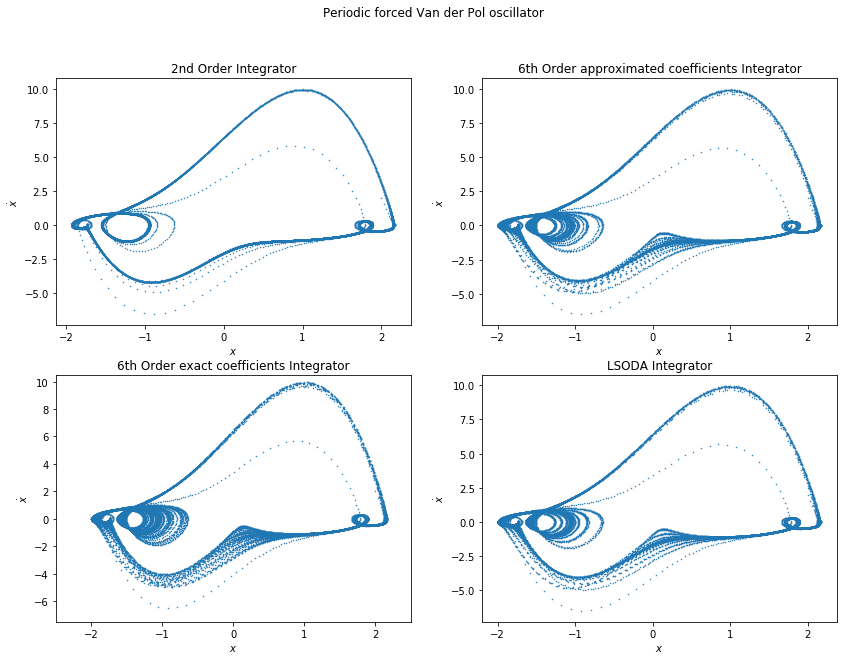

In [36]:
plt.figure(figsize=(14,10))

plt.suptitle("Periodic forced Van der Pol oscillator")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], sols, '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order approximated coefficients Integrator")
plt.plot(solm[:,1], solms,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order exact coefficients Integrator")
plt.plot(sol1[:,1], sol1s,'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.xlim((-2.5,2.5))
plt.ylim((-7.5,10.5))

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

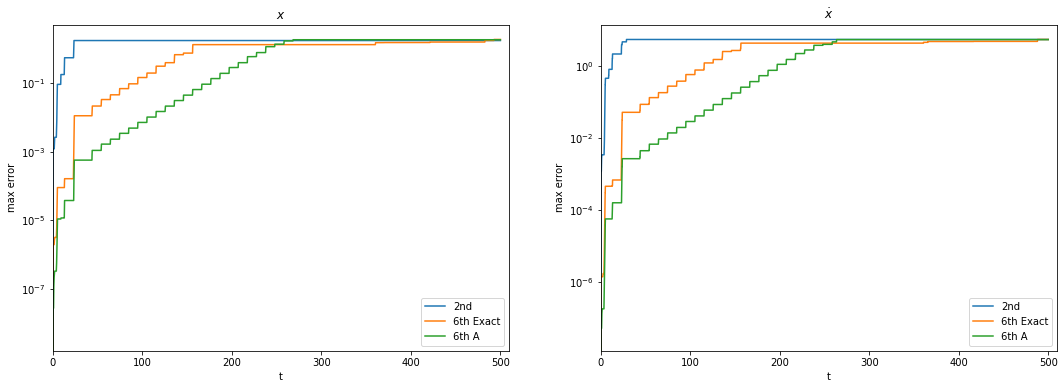

In [37]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label='6th Exact')
plt.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label='6th A')
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sols,y_odeint[:,1]),label="2nd")
plt.plot(tspan,
         err(sol1s,y_odeint[:,1]),label="6th Exact")
plt.plot(tspan,
         err(solms,y_odeint[:,1]),label="6th A")
plt.yscale('log')
plt.xlim(0,510)
plt.legend(loc='lower right')

plt.show()

## Fritzhugh - Nagumo model without external current

In [66]:
def fritzhugh(a, b, c):
    def f(q):
        return -(c-c*q**2-b/c)
    def fq(q):
        return +2.0*q
    def F(q,t):
        return -a+(1-b)*q+(b/3.)*q**3
    def Fq(q,t):
        return (+1-b)+b*q**2
    
    return Lienard(f, fq, F, Fq)

def ytras(q,s,c):
    # q -> x
    return s/c-q+(q**3)/3.

def actras(x,y,c):
    return c *(x+y-(x**3)/3.)

In [78]:
a,b,c=0.7,0.8,3.0
trasy= lambda q, s : ytras(q,s,c) #s->y
trass= lambda x, y : actras(x,y,c) #y->s

x0,y0=-0.650,0
q0,p0,s0=x0, 0, trass(x0,y0)

In [86]:
frinag=fritzhugh(a,b,c)
tspan = np.arange(0, 500, 0.05) 

sol, sols, _ = ic.integrate(step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

In [87]:
def ivp_neu(y, t, a, b,c):
    return [
        c*(y[0] + y[1]-(1.0/3.0)*(y[0])**3),
        -(1/c)*(y[0]-a+b*y[1])
    ]

tspan = np.arange(0, 500, 0.05)

y_init, params = [x0, y0], (a,b,c)
y_odeint, info = si.odeint(ivp_neu, y_init, tspan, params, rtol=1e-13, atol=1e-15, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

Number of function evaluations: 1706, number of Jacobian evaluations: 16


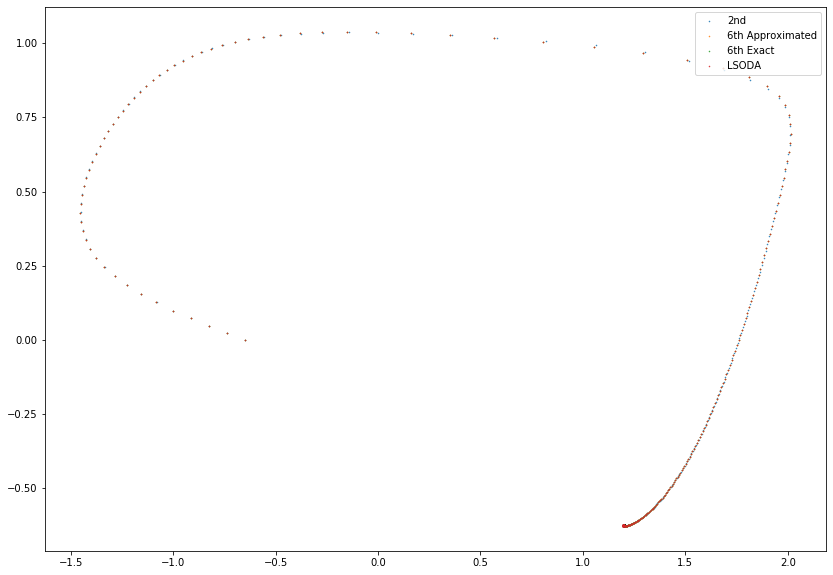

In [88]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], trasy(sol[:,1],sols[:]), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], trasy(solm[:,1],solms[:]),'.',markersize=1,label="6th Approximated")
plt.plot(sol1[:,1], trasy(sol1[:,1],sol1s[:]),'.',markersize=1,label="6th Exact")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.legend(loc="upper right")
plt.show()

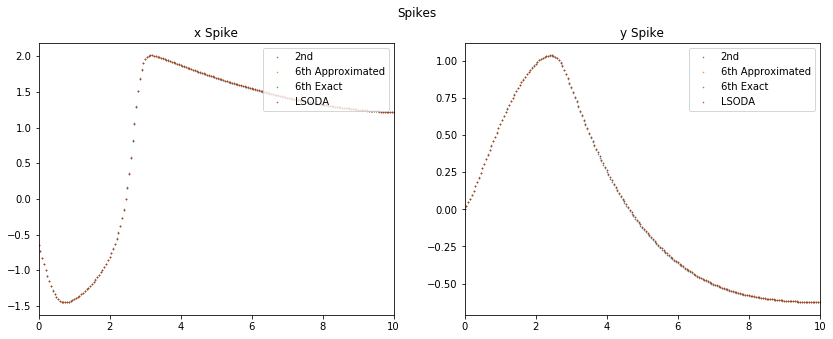

In [89]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=1,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=1,label="6th Approximated")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 0], '.',markersize=1,label="LSODA")
plt.xlim((0,10))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, trasy(sol[:,1],sols[:]), '.',markersize=1,label="2nd")
plt.plot(tspan, trasy(solm[:,1],solms[:]),'.',markersize=1,label="6th Approximated")
plt.plot(tspan, trasy(sol1[:,1],sol1s[:]),'.',markersize=1,label="6th Exact")
plt.plot(tspan, y_odeint[:, 1], '.',markersize=1,label="LSODA")
plt.xlim((0,10))
plt.legend(loc="upper right")

plt.show()

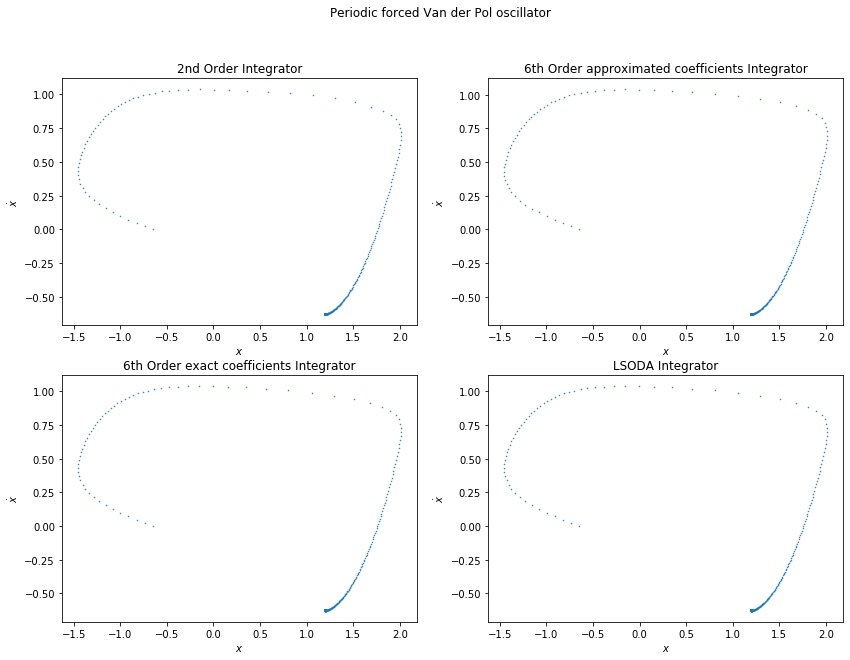

In [90]:
plt.figure(figsize=(14,10))

plt.suptitle("Periodic forced Van der Pol oscillator")
plt.subplot(221)
plt.gca().set_title("2nd Order Integrator")
plt.plot(sol[:,1], trasy(sol[:,1],sols[:]), '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(222)
plt.gca().set_title("6th Order approximated coefficients Integrator")
plt.plot(solm[:,1], trasy(solm[:,1],solms[:]),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(223)
plt.gca().set_title("6th Order exact coefficients Integrator")
plt.plot(sol1[:,1], trasy(sol1[:,1],sol1s[:]),'.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.subplot(224)
plt.gca().set_title("LSODA Integrator")
plt.plot(y_odeint[:, 0], y_odeint[:, 1], '.',markersize=1)
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")

plt.show()

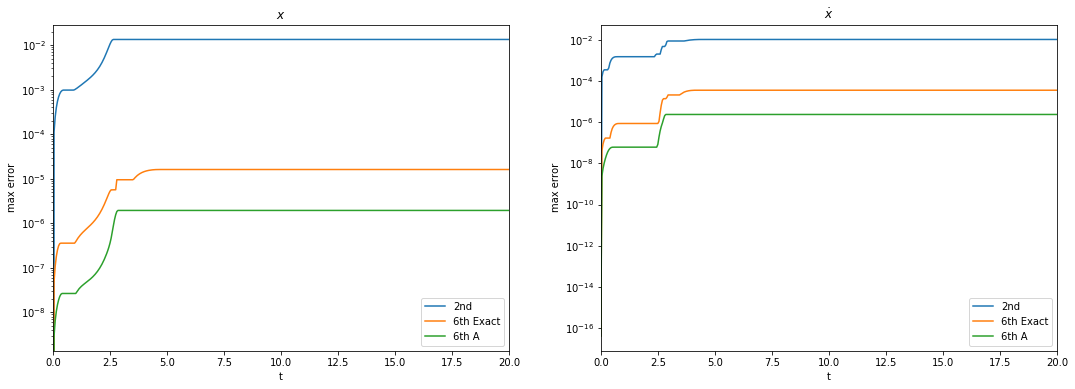

In [91]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],y_odeint[:,0]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],y_odeint[:,0]),label='6th Exact')
plt.plot(tspan,
         err(solm[:,1],y_odeint[:,0]),label='6th A')
plt.yscale('log')
plt.xlim(0,20)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(trasy(sol[:,1],sols),y_odeint[:,1]),label="2nd")
plt.plot(tspan,
         err(trasy(sol1[:,1],sol1s),y_odeint[:,1]),label="6th Exact")
plt.plot(tspan,
         err(trasy(solm[:,1],solms),y_odeint[:,1]),label="6th A")
plt.yscale('log')
plt.xlim(0,20)
plt.legend(loc='lower right')

plt.show()

## Fritzhugh-Nagumo with stimulation

In [102]:
def stim(t):
    return i0*np.heaviside(t,0)-i0*np.heaviside(t-100,0)

def fritzhugh(a, b, c, i0):        
    def f(q):
        return -(c-c*q**2-b/c)
    def fq(q):
        return +2.0*q
    def F(q,t):
        return -a+(1-b)*q+(b/3.)*q**3-b*stim(t)
    def Fq(q,t):
        return (+1-b)+b*q**2
    
    return Lienard(f, fq, F, Fq)

def ytras(q,s,c,t):
    # q -> x
    return s/c-q+(q**3)/3-stim(t)

def actras(x,y,c,t):
    return c *(x+y-(x**3)/3.+stim(t))

In [103]:
a,b,c,i0=0.7,0.8,3.0,-0.4
frinag=fritzhugh(a,b,c,i0)
trasy= lambda q, s, t : ytras(q,s,c,t) #s->y
trass= lambda x, y, t : actras(x,y,c,t) #y->s

x0,y0=-0.650,0
q0,p0,s0=x0, 0, trass(x0,y0,0)

In [104]:
tspan = np.arange(0, 500, 0.05) 

sol, sols, _ = ic.integrate(step1, frinag, tspan, p0, q0, s0)
solm, solms, _ = ic.integrate(step6, frinag, tspan, p0, q0, s0)
sol1, sol1s, _ = ic.integrate(step6e, frinag, tspan, p0, q0, s0)

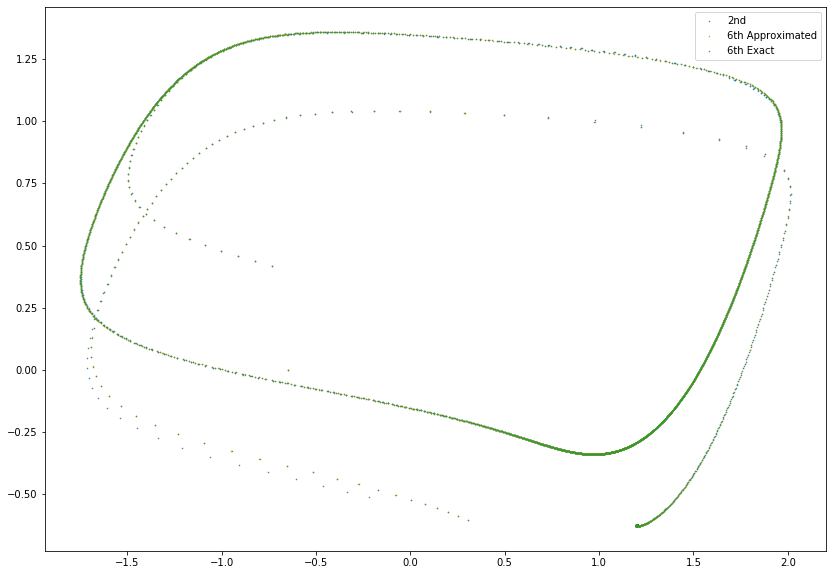

In [105]:
plt.figure(figsize=(14,10))
plt.plot(sol[:,1], (trasy(sol[:,1],sols[:],tspan[:])), '.',markersize=1,label="2nd")
plt.plot(solm[:,1], (trasy(solm[:,1],solms[:],tspan[:])),'.',markersize=1,label="6th Approximated")
plt.plot(sol1[:,1], (trasy(sol1[:,1],sol1s[:],tspan[:])),'.',markersize=1,label="6th Exact")
plt.legend(loc="upper right")
plt.show()

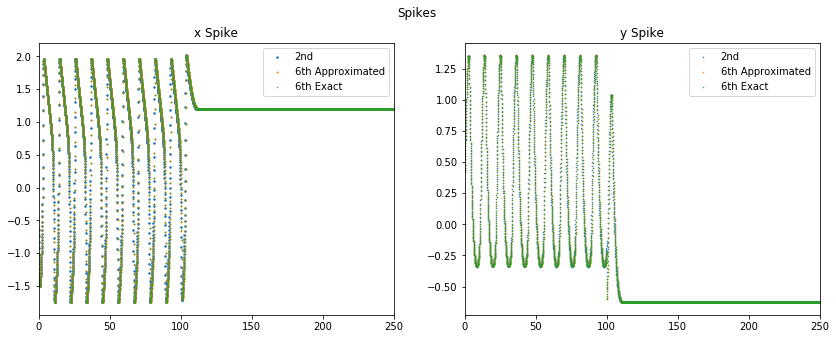

In [106]:
plt.figure(figsize=(14,5))
plt.suptitle("Spikes")
plt.subplot(121)
plt.gca().set_title("x Spike")
plt.plot(tspan, sol[:,1], '.',markersize=3,label="2nd")
plt.plot(tspan, solm[:,1],'.',markersize=2,label="6th Approximated")
plt.plot(tspan, sol1[:,1],'.',markersize=1,label="6th Exact")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.subplot(122)
plt.gca().set_title("y Spike")
plt.plot(tspan, trasy(sol[:,1],sols[:],tspan[:]), '.',markersize=1,label="2nd")
plt.plot(tspan, trasy(solm[:,1],solms[:],tspan[:]),'.',markersize=1,label="6th Approximated")
plt.plot(tspan, trasy(sol1[:,1],sol1s[:],tspan[:]),'.',markersize=1,label="6th Exact")
plt.xlim((0,250))
plt.legend(loc="upper right")

plt.show()

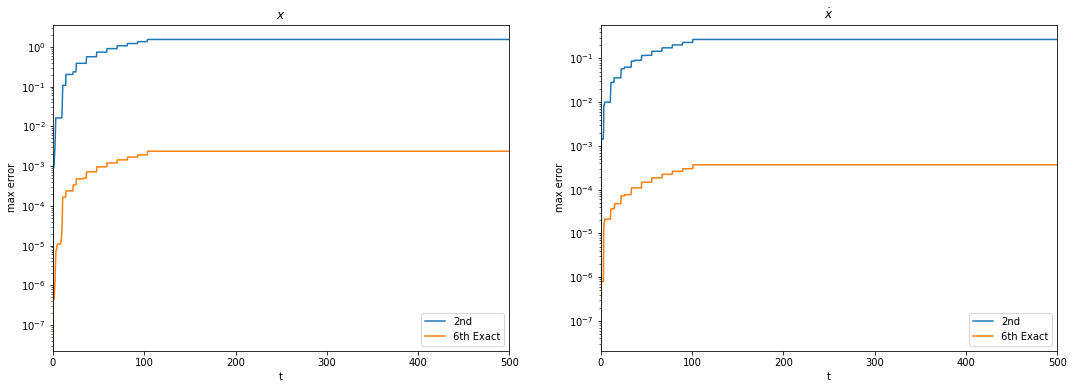

In [107]:
plt.figure(figsize=(18,6))

cut = 0
plt.subplot("121")
plt.title("$x$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(sol[:,1],solm[:,1]),label='2nd')
plt.plot(tspan,
         err(sol1[:,1],solm[:,1]),label='6th Exact')
plt.yscale('log')
plt.xlim(0,500)
plt.legend(loc='lower right')

plt.subplot("122")
plt.title("$\dot{x}$")
plt.xlabel("t")
plt.ylabel("max error")
plt.plot(tspan,
         err(trasy(sol[:,1],sols,tspan),trasy(solm[:,1],solms,tspan)),label="2nd")
plt.plot(tspan,
         err(trasy(sol1[:,1],sol1s,tspan),trasy(solm[:,1],solms,tspan)),label="6th Exact")
plt.yscale('log')
plt.xlim(0,500)
plt.legend(loc='lower right')

plt.show()